## IR Pedestrian Classification Using CNN and Deep ResNet with PyTorch

Outline of the project:

* [Introduction](#1)
* [Packages & Libraries](#3)
* [Data Import and Preparation](#4)
* [CNN Model](#5)
* [Deep Residual Networks (ResNet)](#6)

<a id = "1"></a>
### Introduction

<img src="https://www.researchgate.net/publication/287805480/figure/fig3/AS:668583856201745@1536414221921/Examples-from-the-Classification-Dataset-a-examples-of-pedestrians-and-b-examples.png">

The database consists of FIR images collected from a vehicle driven in outdoors urban scenarios. Images were acquired with an Indigo Omega imager, with a resolution of 164x129 pixels, a grey-level scale of 14 bits, and focal length of 318 pixels. The camera was mounted on the exterior of the vehicle, to avoid infrared filtering of the windshield. Recorded images were manually annotated, where each pedestrian is labelled as a bounding box. To prevent bias introduced by border artifacts their height is subsequently upscaled by 5%. The pedestrians appear in an up-right position.
 
The dataset is divided in two: (i) Classification dataset: positives and randomly sampled negatives with a fixed height-width ratio of (1/2) and rescaled to 64x32 pixels, and (ii) Detection Dataset: Original positive and negative images with annotations.

<a id = "2"></a>
### Packages & Libraries

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch.optim as optim
from torch.autograd import Variable

In [50]:
# for using GPU on local after installation of cuda

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id = "3"></a>
### Data Import and Preparation

In [56]:
def read_images(path, num_img):
    array = np.zeros([num_img, 64*32])
    i = 0
    for img in os.listdir(path):
        img_path = path + "/" + img
        img = Image.open(img_path, mode = "r")
        data = np.asarray(img, dtype = "uint8")
        data = data.flatten()
        array[i, :] = data
        i += 1
        if i == num_img:
            break
    return array

In [57]:
# define a function that returns x and y tensors
def prepare_tensors(path, num_img, label = "negative"):

    array = read_images(path, num_img)
    x_tensor = torch.from_numpy(array)
    if label == "negative":
        y_tensor = torch.zeros(num_img, dtype = torch.long)
    elif label == "positive":
        y_tensor = torch.ones(num_img, dtype = torch.long)
    else:
        return "Error"
    
    return x_tensor, y_tensor

In [60]:
# create paths
train_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Train"
test_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Test"

train_negative_path=train_path + "/neg"
numOf_train_negative_img=42000
train_positive_path=train_path + "/pos"
numOf_train_positive_img=10000

test_negative_path=test_path + "/neg"
numOf_test_negative_img=18056
test_positive_path=test_path + "/pos"
numOf_test_positive_img=5944

In [61]:
# train negative images
x_train_neg_tensor, y_train_neg_tensor = prepare_tensors(train_negative_path, numOf_train_negative_img)
print("Size of X Train Negative Tensor: ", x_train_neg_tensor.size())
print("Size of Y Train Negative Tensor: ", y_train_neg_tensor.size())

Size of X Train Negative Tensor:  torch.Size([42000, 2048])
Size of Y Train Negative Tensor:  torch.Size([42000])


In [62]:
# train positive images
x_train_pos_tensor, y_train_pos_tensor = prepare_tensors(train_positive_path, numOf_train_positive_img, label = "positive")
print("Size of X Train Positive Tensor: ", x_train_pos_tensor.size())
print("Size of Y Train Positive Tensor: ", y_train_pos_tensor.size())

Size of X Train Positive Tensor:  torch.Size([10000, 2048])
Size of Y Train Positive Tensor:  torch.Size([10000])


In [63]:
# test negative images
x_test_neg_tensor, y_test_neg_tensor = prepare_tensors(test_negative_path, numOf_test_negative_img)
print("Size of X Test Negative Tensor: ", x_test_neg_tensor.size())
print("Size of Y Test Negative Tensor: ", y_test_neg_tensor.size())

Size of X Test Negative Tensor:  torch.Size([18056, 2048])
Size of Y Test Negative Tensor:  torch.Size([18056])


In [64]:
print("Size of X Test Negative Tensor: ", x_test_neg_tensor.size())
print("Size of Y Test Negative Tensor: ", y_test_neg_tensor.size())

Size of X Test Negative Tensor:  torch.Size([18056, 2048])
Size of Y Test Negative Tensor:  torch.Size([18056])


In [65]:
# test positive images
x_test_pos_tensor, y_test_pos_tensor = prepare_tensors(test_positive_path, numOf_test_positive_img)
print("Size of X Test Positive Tensor: ", x_test_pos_tensor.size())
print("Size of Y Test Positive Tensor: ", y_test_pos_tensor.size())

Size of X Test Positive Tensor:  torch.Size([5944, 2048])
Size of Y Test Positive Tensor:  torch.Size([5944])


In [66]:
# concat train data
x_train = torch.cat((x_train_neg_tensor,x_train_pos_tensor),0)
y_train = torch.cat((y_train_neg_tensor,y_train_pos_tensor),0)
print("Size of X Train: ",x_train.size())
print("Size of Y Train: ",y_train.size())

Size of X Train:  torch.Size([52000, 2048])
Size of Y Train:  torch.Size([52000])


In [67]:
# concat test data
x_test = torch.cat((x_test_neg_tensor,x_test_pos_tensor),0)
y_test = torch.cat((y_test_neg_tensor,y_test_pos_tensor),0)
print("Size of X Train: ",x_test.size())
print("Size of Y Train: ",y_test.size())

Size of X Train:  torch.Size([24000, 2048])
Size of Y Train:  torch.Size([24000])


Label of the image:  1


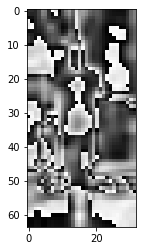

In [68]:
# visualize a random positive image
print("Label of the image: ", y_train[48000].item())
plt.imshow(x_train[48000, :].reshape(64,32), cmap = "gray")

Label of the image:  0


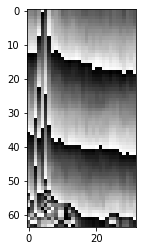

In [69]:
# visualize a random negative image
print("Label of the image: ", y_train[5].item())
plt.imshow(x_train[5, :].reshape(64,32), cmap = "gray")

<a id = "4"></a>
### CNN Model

In [70]:
# hyperparameters
num_epochs = 5
num_classes = 2
batch_size = 2000
learning_rate = 0.0001

In [71]:
# create CNNModel class
class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1= nn.Conv2d(1,10,5)    # 1-input channel, 10-output channel, 3- kernel size 3x3
        self.pool= nn.MaxPool2d(2,2)     # max pooling (2x2)
        self.conv2= nn.Conv2d(10,16,5)   # 10-input channel, 16-output channel, 3- kernel size 3x3
        
        self.fc1=nn.Linear(16*13*5,520)   # fully connected layers (input, output)
        self.fc2=nn.Linear(520,130)          
        self.fc3=nn.Linear(130,num_classes)
        
    def forward(self, x):
        # Convolution 1 and max pooling
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool(out)
        
        # Convolution 2 and max pooling
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        # flatten
        out = torch.flatten(out, 1)
        
        # Linear function (readout)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

In [72]:
# prepare data for modelling
train = torch.utils.data.TensorDataset(x_train, y_train)
trainLoader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(x_test, y_test)
testLoader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [73]:
# instantiate model
model = CNNModel()

In [74]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.8)

In [75]:
# training model
start = time.time()

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

use_gpu = False

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainLoader, 0):
        
        train = Variable(images.view(batch_size, 1, 64, 32).float())
        labels = Variable(labels)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model(train)
        
        # calculate softmax and cross entropy loss
        loss = criterion(outputs, labels)
        
        # calculating gradients
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        count += 1
        
        if count % 5 == 0:
            # calculate accuracy
            correct = 0
            total = 0
            # iterate through test dataset
            with torch.no_grad(): # close back prop
                
                for images, labels in testLoader:

                    test = Variable(images.view(batch_size, 1, 64, 32).float())

                    # forward propagation
                    outputs = model(test)

                    # get prediction from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
        if count % 10 == 0:
            # print loss
            print("Iteration: {} Loss: {} Accuracy: {}".format(count, loss.data, accuracy))


stop = time.time()
time_difference = (stop - start) / 60
print("Process time: ", time_difference)

Iteration: 10 Loss: 0.4269248843193054 Accuracy: 95.09583333333333
Iteration: 20 Loss: 0.36015480756759644 Accuracy: 91.9125
Iteration: 30 Loss: 0.33145520091056824 Accuracy: 90.67916666666666
Iteration: 40 Loss: 0.31284260749816895 Accuracy: 91.59583333333333
Iteration: 50 Loss: 0.29085150361061096 Accuracy: 90.24583333333334
Iteration: 60 Loss: 0.29905492067337036 Accuracy: 90.29166666666667
Iteration: 70 Loss: 0.2757546007633209 Accuracy: 90.67083333333333
Iteration: 80 Loss: 0.27543845772743225 Accuracy: 90.35
Iteration: 90 Loss: 0.27280908823013306 Accuracy: 89.53333333333333
Iteration: 100 Loss: 0.23788069188594818 Accuracy: 88.175
Iteration: 110 Loss: 0.25998806953430176 Accuracy: 90.92916666666666
Iteration: 120 Loss: 0.2612049877643585 Accuracy: 87.49166666666666
Iteration: 130 Loss: 0.23873598873615265 Accuracy: 90.0125
Process time:  1.2332865317662558


In [76]:
# save model
path = './pedestrian.pth'
torch.save(model.state_dict(), path)

<a id = "5"></a>
### Deep ResNet

One of the problems ResNets solve is the famous known vanishing gradient. This is because when the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.

With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.

<img src="https://d2l.ai/_images/residual-block.svg">

In [77]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)    
def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

In [78]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self,inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

In [95]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride = 2, padding = 3, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
    
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.inplanes, planes*block.expansion, stride),
                    nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
        
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x

In [96]:
model = ResNet(BasicBlock,[2,2,2])

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [101]:
# hyperparameters
num_epochs = 20
num_classes = 2
batch_size = 2000
learning_rate = 0.0001

In [102]:
start = time.time()

train_acc = []
test_acc = []
loss_list = []
use_gpu = False

total_step = len(trainLoader)
for epoch in range(num_epochs):
    for i, data in enumerate(trainLoader):
        
        images, labels = data
        images = images.view(batch_size, 1, 64, 32) # reshape
        images = images.float() # float
        
        # use gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
                
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels)
        
        # zero gradient
        optimizer.zero_grad()
        
        # backward
        loss.backward()
        
        # update weights
        optimizer.step()
    if epoch % 10 == 0:    
        print("Epoch : ", epoch)
    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainLoader:
            images, labels= data
            
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data,1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch % 10 == 0:    
        print("Accuracy Train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testLoader:
            images, labels= data
            
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data,1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch % 10 == 0:    
        print("Accuracy Test %d %%"%(100*correct/total))
    test_acc.append(100*correct/total)

    loss_list.append(loss.item())
    
print("**************")
print("Train Is Done")
print("**************")
end = time.time()
total_time = (end-start)/60
print("Process Time : ",total_time)

Epoch :  0
Accuracy Train 84 %
Accuracy Test 86 %
Epoch :  10
Accuracy Train 93 %
Accuracy Test 77 %
**************
Train Is Done
**************
Process Time :  13.076080588499705


Applied a deep residual network and cnn with PyTorch. Thanks!